In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import env

# DBSCAN import
from sklearn.cluster import DBSCAN

# Scaler import
from sklearn.preprocessing import MinMaxScaler

### Clustering - DBSCAN

- Use DBSCAN to detect anomalies in requests from the curriculum access logs in the curriculum_logs database.

In [2]:
# acquire the data
# function to get curriculum data
def get_curriculum_logs():
    if os.path.isfile("curriculum_logs.csv"):
        return pd.read_csv("curriculum_logs.csv", index_col=False)
    else:
        # read sql query into dataframe
        url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
        sql = '''
        SELECT date, time, path, ip, user_id, name, program_id, start_date, end_date
        FROM logs
        JOIN cohorts ON logs.cohort_id = cohorts.id;
        '''
        df = pd.read_sql(sql, url)

        # dataframe to csv
        df.to_csv("curriculum_logs.csv", index = False)

        return df
# get data    
logs = get_curriculum_logs()
logs.head()

,date,time,path,ip,user_id,name,program_id,start_date,end_date
0,2018-01-26,09:55:03,/,97.105.19.61,1,Hampton,1,2015-09-22,2016-02-06
1,2018-01-26,09:56:02,java-ii,97.105.19.61,1,Hampton,1,2015-09-22,2016-02-06
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,97.105.19.61,1,Hampton,1,2015-09-22,2016-02-06
3,2018-01-26,09:56:06,slides/object_oriented_programming,97.105.19.61,1,Hampton,1,2015-09-22,2016-02-06
4,2018-01-26,09:56:24,javascript-i/conditionals,97.105.19.61,2,Teddy,2,2018-01-08,2018-05-17


In [3]:
# join date and time columns
logs['date_time'] = logs['date'] + ' ' + logs['time']
# convert to datetime
logs['date_time'] = pd.to_datetime(logs['date_time'])
# set as index
logs = logs.set_index('date_time')
logs.head()

,date,time,path,ip,user_id,name,program_id,start_date,end_date
date_time,,,,,,,,,
2018-01-26 09:55:03,2018-01-26,09:55:03,/,97.105.19.61,1,Hampton,1,2015-09-22,2016-02-06
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,97.105.19.61,1,Hampton,1,2015-09-22,2016-02-06
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,97.105.19.61,1,Hampton,1,2015-09-22,2016-02-06
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,97.105.19.61,1,Hampton,1,2015-09-22,2016-02-06
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,97.105.19.61,2,Teddy,2,2018-01-08,2018-05-17


In [4]:
# total page views and n_unique pages viewed
pages = logs.groupby(['user_id'])['path'].agg(['count', 'nunique'])
pages

,count,nunique
user_id,,
1,7404,976
2,1541,151
3,1562,169
4,692,143
5,1701,197
...,...,...
977,86,12
978,55,18
979,127,20


In [5]:
# scale the data using minmax scaler
scaler = MinMaxScaler()
scaler.fit(pages)
scaled_pages = scaler.transform(pages)
scaled_pages

array([[4.13298347e-01, 1.00000000e+00],
       [8.59758821e-02, 1.53846154e-01],
       [8.71482805e-02, 1.72307692e-01],
       ...,
       [7.03439035e-03, 1.94871795e-02],
       [1.11656990e-04, 0.00000000e+00],
       [2.28896829e-03, 8.20512821e-03]])

In [6]:
# DBSCAN clustering
dbs = DBSCAN(eps=0.1, min_samples=4).fit(scaled_pages)
print(dbs)

DBSCAN(eps=0.1, min_samples=4)


In [7]:
# add scaled values to the dataframe
pages['scale_count'] = scaled_pages[:, 0]
pages['scale_nunique'] = scaled_pages[:, 1]
pages

,count,nunique,scale_count,scale_nunique
user_id,,,,
1,7404,976,0.413298,1.000000
2,1541,151,0.085976,0.153846
3,1562,169,0.087148,0.172308
4,692,143,0.038577,0.145641
5,1701,197,0.094908,0.201026
...,...,...,...,...
977,86,12,0.004745,0.011282
978,55,18,0.003015,0.017436
979,127,20,0.007034,0.019487


In [8]:
# look at dbscan array
labels = dbs.labels_
labels[0:10]

array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [9]:
# add the labels to the dataframe
pages['labels'] = labels

In [10]:
pages.labels.value_counts()

 0    906
-1      5
Name: labels, dtype: int64

In [11]:
# isolate anomalies
anomalies = pages[pages.labels == -1]
anomalies

,count,nunique,scale_count,scale_nunique,labels
user_id,,,,,
1,7404,976,0.413298,1.000000,-1
11,17913,871,1.000000,0.892308,-1
53,12329,333,0.688254,0.340513,-1
64,16322,436,0.911177,0.446154,-1
248,5075,625,0.283274,0.640000,-1


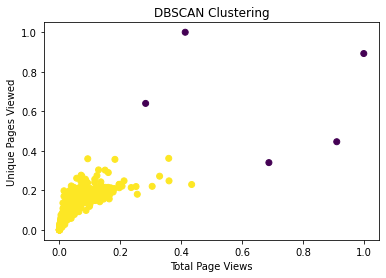

In [17]:
# plot the data
plt.scatter(pages['scale_count'], pages['scale_nunique'], c=pages.labels)
# add labels
plt.xlabel('Total Page Views')
plt.ylabel('Unique Pages Viewed')
plt.title('DBSCAN Clustering')
plt.show();

- Use DBSCAN to detect anomalies in other products from the customers dataset. The database name is grocery_db.
- Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

In [ ]:
def get_grocery_db():
    if os.path.isfile("grocery_db.csv"):
        return pd.read_csv("curriculum_logs.csv", index_col=False)
    else:
        # read sql query into dataframe
        url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
        sql = '''
        SELECT date, time, path, ip, user_id, name, program_id, start_date, end_date
        FROM logs
        JOIN cohorts ON logs.cohort_id = cohorts.id;
        '''
        df = pd.read_sql(sql, url)

        # dataframe to csv
        df.to_csv("curriculum_logs.csv", index = False)

        return df